In [1]:
import os
#os.environ['HF_HOME'] = '/workspace/huggingface'

from transformer_lens import HookedTransformer, ActivationCache, utils
import torch

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

init_notebook_mode(connected=True)

Device: mps


In [2]:
model = HookedTransformer.from_pretrained('gpt2', device=device)

model.eval()
model.set_use_attn_result(True)
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_split_qkv_input(True)

Loaded pretrained model gpt2 into HookedTransformer


In [5]:
clean_prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
    "name": "Davide",
    "age": "20",
    "city": "Rome"
}

My name is Paul and I live in San Francisco. I've just turned 12.
{
    "name": "'''

corrupted_prompt = '''I'm Davide and I'm 20 years old.
{
    "name": "Davide",
    "age": "20"
}

Hi, I'm Laura and I'm 25.
{
    "name": "'''

#My name is Paul and I've just turned 12.
#{
#    "name": "Paul",
#    "age": 12
#} Hi, I'm Laura and I'm 25.

""" clean_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

corrupted_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

John works at Walmart while Susan studies at NYU.
{
    "entities": [
        {"id": 0, "name": "''' """

' clean_prompt = \'\'\'David is a student at Stanford and Mary works at McDonald.\n{\n    "entities": [\n        {"id": 0, "name": "Davide"},\n        {"id": 1, "name": "Stanford"},\n        {"id": 2, "name": "Mary"},\n        {"id": 3, "name": "McDonald"}\n    ]\n}\n\nSusan works at Walmart while John studies at NYU.\n{\n    "entities": [\n        {"id": 0, "name": "\'\'\'\n\ncorrupted_prompt = \'\'\'David is a student at Stanford and Mary works at McDonald.\n{\n    "entities": [\n        {"id": 0, "name": "Davide"},\n        {"id": 1, "name": "Stanford"},\n        {"id": 2, "name": "Mary"},\n        {"id": 3, "name": "McDonald"}\n    ]\n}\n\nJohn works at Walmart while Susan studies at NYU.\n{\n    "entities": [\n        {"id": 0, "name": "\'\'\' '

### Patching

In [6]:
from transformer_lens.utils import test_prompt

test_prompt(clean_prompt, 'positive', model)

Tokenized prompt: ['<|endoftext|>', 'I', "'m", ' Dav', 'ide', ',', ' I', "'m", ' 20', ' years', ' old', ' and', ' I', ' live', ' in', ' Rome', '.', '\n', '{', '\n', ' ', ' ', ' ', ' "', 'name', '":', ' "', 'D', 'av', 'ide', '",', '\n', ' ', ' ', ' ', ' "', 'age', '":', ' "', '20', '",', '\n', ' ', ' ', ' ', ' "', 'city', '":', ' "', 'R', 'ome', '"', '\n', '}', '\n', '\n', 'My', ' name', ' is', ' Paul', ' and', ' I', ' live', ' in', ' San', ' Francisco', '.', ' I', "'ve", ' just', ' turned', ' 12', '.', '\n', '{']
Tokenized answer: [' positive']


Performance on answer token:
Rank: 10815    Logit:  1.69 Prob:  0.00% Token: | positive|

Top 0th token. Logit: 14.79 Prob: 44.28% Token: | |
Top 1th token. Logit: 14.43 Prob: 30.95% Token: |
|
Top 2th token. Logit: 12.43 Prob:  4.20% Token: | }|
Top 3th token. Logit: 12.37 Prob:  3.94% Token: |  |
Top 4th token. Logit: 11.61 Prob:  1.85% Token: | "|
Top 5th token. Logit: 10.48 Prob:  0.60% Token: | |
Top 6th token. Logit: 10.10 Prob:  0.41% Token: | {|
Top 7th token. Logit: 10.00 Prob:  0.37% Token: | I|
Top 8th token. Logit:  9.95 Prob:  0.35% Token: |<|endoftext|>|
Top 9th token. Logit:  9.90 Prob:  0.33% Token: |I|


Ranks of the answer tokens: [(' positive', 10815)]

In [7]:
import os
import sys

current_dir = os.getcwd()
atp_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
sys.path.append(atp_dir)

from atp import Patching

patching = Patching(model, 'atp')

In [ ]:
a_clean = ' positive'
a_corr = ' negative'

a_clean_token = model.to_single_token(a_clean)

patching.patching(clean_prompt, a_clean, corrupted_prompt, a_corr, component='attn_all')

In [84]:
fig = patching.plot()
fig.write_html("fig.html")

In [158]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [10]:
# [(8, 11, -1), (9, 6, 1), (9, 9, 1), (10, 0, 1), (10, 1, 1), (10, 7, -1), (10, 10, 1), (11, 10, -1)]
heads = [(8, 11), (9, 6), (10, 0), (10, 1)]
# 9,9
topk_token_probas = []  # List to store topk token probabilities
lams = np.linspace(1, 10, 50)

for lam in tqdm(lams):
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(corrupted_prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)
        
        if lam == 1:
            vals, idxs = proba.topk(8, dim=-1)
            initial_tokens = idxs[0, -1].cpu().tolist()
            if a_clean_token not in initial_tokens:
                initial_tokens.append(a_clean_token)
        else:
            vals = proba[..., initial_tokens]
        
        topk_token_probas.append(vals[0, -1, :].cpu().numpy().tolist())


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 50/50 [00:04<00:00, 11.19it/s]


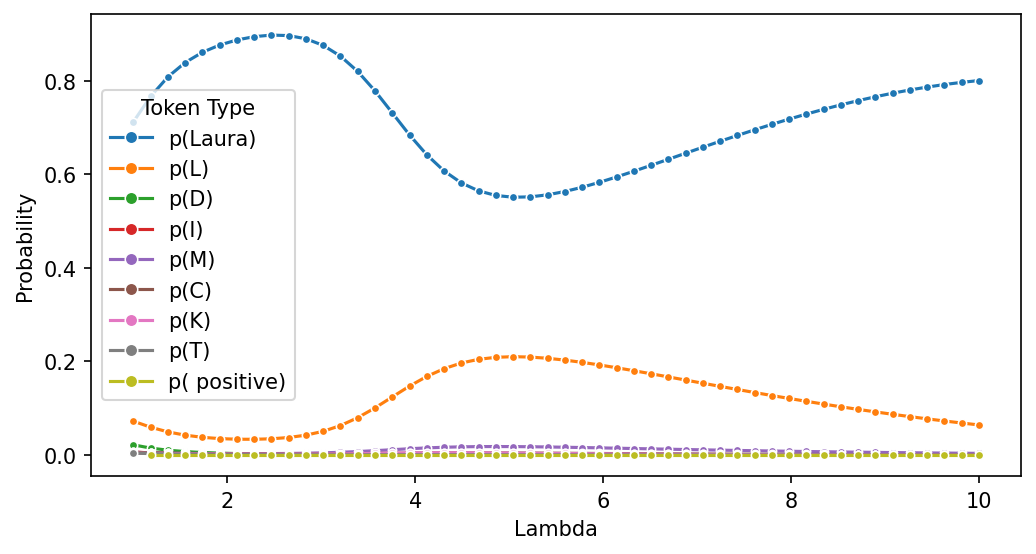

In [11]:
import pandas as pd

fig = plt.figure(figsize=(8, 4), dpi=150)

data = pd.DataFrame(topk_token_probas, columns=[f"p({tok})" for tok in model.to_str_tokens(torch.tensor(initial_tokens))])
data['Lambda'] = lams
data = data.melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')

ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')
tmp =[line.set_markersize(4) for line in ax.lines]

In [155]:
prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
"name": "Davide",
"age": "20",
"city": "Rome"
}

My name is Susan and I live in San Francisco. I've just turned 12.
{'''

#prompt = '''<html> <h1> <p>
#</p> </h1> </html>
#
#<div> <h1>
#</h1> </div>
#
#<html> <h1> <div>
#'''

In [156]:
print(model.generate(prompt, stop_at_eos=False, temperature=0, max_new_tokens=32))

  0%|          | 0/32 [00:00<?, ?it/s]

I'm Davide, I'm 20 years old and I live in Rome.
{
"name": "Davide",
"age": "20",
"city": "Rome"
}

My name is Susan and I live in San Francisco. I've just turned 12.
{

"name": "Susan",

"age": "20",

"city": "San Francisco"

}

My name


In [162]:
heads = [(8, 11), (9, 6), (10, 0), (10, 1)]
lam = 5

tokens = model.to_tokens(prompt)
max_new_tokens = 32

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 32/32 [00:04<00:00,  7.63it/s]

<|endoftext|>I'm Davide, I'm 20 years old and I live in Rome.
{
"name": "Davide",
"age": "20",
"city": "Rome"
}

My name is Susan and I live in San Francisco. I've just turned 12.
{

"name": "Susan",

"age": "12",

"city": "San Francisco"

}

I'm


In [165]:
def head_modifier_hook(x, hook, lam):
    x = lam[None, None, :, None] * x # b pos head dim
    return x

In [366]:
prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
"name": "Davide",
"age": "20",
"city": "Rome"
}

My name is Susan and I live in San Francisco. I've just turned 12.
{
"name": "Susan",
"age": "12",
"city": "San Francisco"
}'''

prompt = '''<html> <h1> <p>
</p> </h1> </html>

<div> <h1>
</h1> </div>

<html> <h1> <div>
</div> </h1> </html>

<h1> <div> <p>
</p> </div> </h1>'''

prompt = '''happy -> sad
exciting -> boring
fast -> slow
big -> small'''

prompt = '''David is a student at Stanford and Mary works at McDonald.
{
"entities": [
{"id": 0, "name": "Davide"},
{"id": 1, "name": "Stanford"},
{"id": 2, "name": "Mary"},
{"id": 3, "name": "McDonald"}
]
}

Susan works at Walmart while John studies at NYU.
{
"entities": [
{"id": 0, "name": "Susan"},
{"id": 1, "name": "Walmart"},
{"id": 2, "name": "John"},
{"id": 3, "name": "NYU"}
]
}

Chris is a works at GCB and Laura works at Burger King.
{
"entities": [
{"id": 0, "name": "Chris"},
{"id": 1, "name": "GCB"},
{"id": 2, "name": "Laura"},
{"id": 3, "name": "Burger King"}
]
}'''

In [367]:
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, '"'),
 (17, 'ent'),
 (18, 'ities'),
 (19, '":'),
 (20, ' ['),
 (21, '\n'),
 (22, '{"'),
 (23, 'id'),
 (24, '":'),
 (25, ' 0'),
 (26, ','),
 (27, ' "'),
 (28, 'name'),
 (29, '":'),
 (30, ' "'),
 (31, 'D'),
 (32, 'av'),
 (33, 'ide'),
 (34, '"},'),
 (35, '\n'),
 (36, '{"'),
 (37, 'id'),
 (38, '":'),
 (39, ' 1'),
 (40, ','),
 (41, ' "'),
 (42, 'name'),
 (43, '":'),
 (44, ' "'),
 (45, 'Stan'),
 (46, 'ford'),
 (47, '"},'),
 (48, '\n'),
 (49, '{"'),
 (50, 'id'),
 (51, '":'),
 (52, ' 2'),
 (53, ','),
 (54, ' "'),
 (55, 'name'),
 (56, '":'),
 (57, ' "'),
 (58, 'Mary'),
 (59, '"},'),
 (60, '\n'),
 (61, '{"'),
 (62, 'id'),
 (63, '":'),
 (64, ' 3'),
 (65, ','),
 (66, ' "'),
 (67, 'name'),
 (68, '":'),
 (69, ' "'),
 (70, 'Mc'),
 (71, 'Donald'),
 (72, '"}'

In [ ]:
print(model.generate(prompt, stop_at_eos=False, temperature=0, max_new_tokens=1))

In [370]:
# Tuned lambdas
lambdas = torch.nn.Parameter(torch.ones(
    (model.cfg.n_layers, model.cfg.n_heads), device=device), requires_grad=True
)

optimizer = torch.optim.Adam([lambdas], lr=0.1) 

for param in model.parameters():
    param.requires_grad = False
    
slices = [(89, 150), (167, 229)] # (64, 88) - (31, 37), (51, 60), (74, 83) - (7, 8), (11, 12), (15, 16)
idxs = []
for s in slices:
    idxs.extend(range(s[0], s[1]))
idxs = torch.tensor(idxs, requires_grad=False, device=device)

tokens = model.to_tokens(prompt)
labels = tokens[:, idxs+1]

In [371]:
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()
losses = []

for e in tqdm(range(30)):
    proba = model.run_with_hooks(
                tokens,
                fwd_hooks=[
                    (
                        f"blocks.{l}.attn.hook_result",
                        partial(head_modifier_hook, lam=lambdas[l]),
                    ) for l in range(4, model.cfg.n_layers)
                ]
            ).softmax(-1)[:, idxs]
    
    loss = loss_fn(proba.view(-1, model.cfg.d_vocab), labels.view(-1))
    losses.append(loss.item())

    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()        # Compute gradients for `lambdas`
    optimizer.step() 

100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


In [372]:
import plotly.express as px

px.line(y=losses, title='Loss over epochs')

In [373]:
lambdas

Parameter containing:
tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000],
        [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  1.0000,  1.0000],
        [-0.5463,  1.1644,  0.2921,  1.9761,  1.5987,  2.1064,  0.8197,  0.6979,
          0.1543,  1.6778,  2.1411,  1.1882],
        [ 1.6947,  1.8993,  0.6943,  2.6714, -1.1193,  2.5163,  1.9655,  2.3320,
          1.2787,  1.1025, -0.1397,  0.2474],
        [ 0.4045,  1.9636,  1.6291,  0.6703,  0.4925,  0.1527,  0.9084,  1.1047,
          1.2040,  1.6551,  2.1726,  0.6952],
        [ 2.1145,  2.8208,  2.3037,  0.3856,  1.8442,  1.4327,  1.4550,  1.4119,
        

In [377]:
test_prompt = '''I'm Davide, I'm 20 years old and I live in Rome.
{
    "name": "Davide",
    "age": "20",
    "city": "Rome"
}

I'm Luisa and I live in New York. I'm 42 years old.
{'''

test_prompt = '''<html> <h1> <p>
</p> </h1> </html>

<div> <h1>
</h1> </div>

<h1> <div> <p>
'''

test_prompt = '''<html> <h1> <p>
</p> </h1> </html>

<h1> <div> <p>
'''

test_prompt = '''happy -> sad
exciting -> boring
fast -> slow
short ->'''

test_prompt = '''David is a student at Stanford and Mary works at McDonald.
{
"entities": [
{"id": 0, "name": "Davide"},
{"id": 1, "name": "Stanford"},
{"id": 2, "name": "Mary"},
{"id": 3, "name": "McDonald"}
]
}

Susan works at Walmart while John studies at NYU.
{
"entities": [
{"id": 0, "name": "Susan"},
{"id": 1, "name": "Walmart"},
{"id": 2, "name": "John"},
{"id": 3, "name": "NYU"}
]
}

Chris is a works at GCB and Laura works at Burger King.
'''

In [380]:
print(model.generate(test_prompt, stop_at_eos=False, temperature=0, max_new_tokens=64))

  0%|          | 0/64 [00:00<?, ?it/s]

David is a student at Stanford and Mary works at McDonald.
{
"entities": [
{"id": 0, "name": "Davide"},
{"id": 1, "name": "Stanford"},
{"id": 2, "name": "Mary"},
{"id": 3, "name": "McDonald"}
]
}

Susan works at Walmart while John studies at NYU.
{
"entities": [
{"id": 0, "name": "Susan"},
{"id": 1, "name": "Walmart"},
{"id": 2, "name": "John"},
{"id": 3, "name": "NYU"}
]
}

Chris is a works at GCB and Laura works at Burger King.
{

"entities": [

{"id": 0, "name": "Chris"},

{"id": 1, "name": "Laura"},

{"id": 2, "name": "John"},

{"id": 3, "name": "John"}

]



In [381]:
tokens = model.to_tokens(test_prompt)
max_new_tokens = 64

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, lam=lambdas[l]),
                ) for l in range(model.cfg.n_layers)
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 64/64 [02:01<00:00,  1.89s/it]


<|endoftext|>David is a student at Stanford and Mary works at McDonald.
{
"entities": [
{"id": 0, "name": "Davide"},
{"id": 1, "name": "Stanford"},
{"id": 2, "name": "Mary"},
{"id": 3, "name": "McDonald"}
]
}

Susan works at Walmart while John studies at NYU.
{
"entities": [
{"id": 0, "name": "Susan"},
{"id": 1, "name": "Walmart"},
{"id": 2, "name": "John"},
{"id": 3, "name": "NYU"}
]
}

Chris is a works at GCB and Laura works at Burger King.
{
"entities": [
{"id": 0, "name": "Chris"},
{"id": 1, "name": "Laura"},
{"id": 2, "name": "Burger King"}
]
}

{
"entities": [
{"id": 0,


### AtP

In [103]:
patching = Patching(model, 'atp')

In [106]:
x_clean = clean_prompt
x_corr = corrupted_prompt

a_clean = 'Susan'
a_corr = 'John'

patching.patching(x_clean, a_clean, x_corr, a_corr, component='attn_k')

Clean logit difference: -2.828
Corrupted logit difference: -2.330
Patching...


In [107]:
fig = patching.plot()
fig.write_html("fig.html")

Promoting heads: L8H11, L9H6, L9H9, L10H0, L10H1, L10H10

Suppression heads: L10H7, L10H11

In [245]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "Walmart"},
        {"id": 2, "name": "Susan"},'''

In [246]:
def logits_diff(logits, ans, topk=5):
    top_tokens = logits[0, -1].topk(topk).indices.tolist()
    if isinstance(ans, str):
        ans = model.to_single_token(ans)

    if ans in top_tokens:
        top_tokens.remove(ans)
        
    return logits[0, -1, ans] - logits[0, -1, top_tokens].mean(-1)
    
def get_cache_fwd_and_bwd(tokens, ans):
        filter_not_qkv_input = lambda name: "_input" not in name
        model.reset_hooks()
        cache = {}

        def forward_cache_hook(act, hook):
            cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")

        grad_cache = {}

        def backward_cache_hook(act, hook):
            grad_cache[hook.name] = act.detach()

        model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")

        value = logits_diff(model(tokens), ans, topk=10)
        value.backward()
        model.reset_hooks()
        return (
            value.item(),
            ActivationCache(cache, model),
            ActivationCache(grad_cache, model),
        )

In [247]:
tokens = model.to_tokens(prompt)
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [248]:
import einops
from tqdm import tqdm

first_output_token_id = 124

patch = torch.zeros(144, len(tokens[0]) - first_output_token_id)

for i in tqdm(range(first_output_token_id, len(tokens[0]))):
    _, cache, grad_cache = get_cache_fwd_and_bwd(tokens[:, :i], tokens[0, i])

    act = cache.stack_head_results(-1)
    grad_act = grad_cache.stack_head_results(-1)

    patch[:, i-first_output_token_id] = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos",
                "sum",
            )[:, -1]

100%|██████████| 68/68 [00:08<00:00,  8.20it/s]


In [249]:
import plotly.express as px
ys = [f'L{i}H{j}' for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
xs = [f"{tok} | {i}" for i, tok in enumerate(model.to_str_tokens(prompt)[first_output_token_id:])]

fig = px.imshow(
    patch.cpu().numpy(), 
    x=xs,
    y=ys,
    title=f"Patching results for AtP method",
    color_continuous_scale='RdBu', zmin=-1, zmax=1, aspect='auto'
)
fig.write_html("fig.html")

In [250]:
import plotly.express as px
import numpy as np

layer_id = 8
head_id = 11

data = cache[f'blocks.{layer_id}.attn.hook_pattern'][0, head_id].cpu()
labels = [f"{tok} ({i})" for i, tok in enumerate(model.to_str_tokens(prompt)[:-1])]

# Create the plot using Plotly Express
fig = px.imshow(
    data,
    labels=dict(x="Keys", y="Queries", color="Attention Score"),
    x=labels,
    y=labels,
    title=f'Attention patter at head {head_id} of layer {layer_id}',
    color_continuous_scale="Blues"
)

# Adjust the layout for better readability
fig.update_xaxes(tickangle=35)
fig.update_layout(coloraxis_colorbar=dict(title="Score"))

# Show the plot
fig.write_html("attn_pattern.html")

In [336]:
# Pattern modifier
start = 113
end = 123

def pattern_modifier_hook(x, hook, head_id, pos):
    name_tokens = start + x[:, head_id, pos, start:end].sort(descending=True).indices[0, :4]
    #x[:, head_id, pos, name_tokens] = x[:, head_id, pos, name_tokens].sum() / len(name_tokens)
    #print(name_tokens)
    x[:, head_id, pos, 113] = x[:, head_id, pos, 113] + 10
    #x[:, head_id, pos] = x[:, head_id, pos].softmax(-1)
    return x

In [337]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

In [338]:
print(model.generate(prompt, max_new_tokens=32, temperature=0))

  0%|          | 0/32 [00:00<?, ?it/s]

David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "John"},
        {"id": 1, "name": "John"},
        {"id":


In [339]:
heads = [(8, 3), (8, 11)]
token_ids = [model.to_single_token(tok) for tok in ['Susan', 'John']]
pos = -1

tokens = model.to_tokens(clean_prompt)
max_new_tokens = 32

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_pattern",
                    partial(pattern_modifier_hook, head_id=h, pos=pos),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]
        
        probas = proba[..., token_ids]
        tokens = torch.cat([tokens, new_tok], dim=-1)

100%|██████████| 32/32 [00:00<00:00, 38.12it/s]


In [342]:
print(model.to_string(tokens)[0])

<|endoftext|>David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan Susan


In [341]:
probas[0, -1]

tensor([0.0002, 0.0006], device='cuda:0')

## SAEs

In [35]:
from huggingface_hub import snapshot_download

REPO_ID = "jbloom/GPT2-Small-SAEs-Reformatted"
path = snapshot_download(repo_id=REPO_ID)

Fetching 41 files:   0%|          | 0/41 [00:00<?, ?it/s]

In [36]:
from sae_lens import LMSparseAutoencoderSessionloader
from tqdm import tqdm
import os

saes = []

for l in tqdm(range(model.cfg.n_layers)):
    _, sae_group, activation_store = LMSparseAutoencoderSessionloader.load_pretrained_sae(
        path = os.path.join(path, f"blocks.{l}.hook_resid_pre"), device=device
    )
    sae_group.eval()
    saes.append(sae_group[f'blocks.{l}.hook_resid_pre'])

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning:

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.

  8%|▊         | 1/12 [00:12<02:15, 12.29s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 17%|█▋        | 2/12 [00:22<01:50, 11.05s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 25%|██▌       | 3/12 [00:28<01:20,  8.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 33%|███▎      | 4/12 [00:35<01:03,  7.88s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 42%|████▏     | 5/12 [00:40<00:48,  6.93s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 50%|█████     | 6/12 [00:50<00:48,  8.02s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 58%|█████▊    | 7/12 [00:57<00:38,  7.77s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 67%|██████▋   | 8/12 [01:03<00:28,  7.24s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 75%|███████▌  | 9/12 [01:09<00:20,  6.80s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 83%|████████▎ | 10/12 [01:25<00:18,  9.43s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


 92%|█████████▏| 11/12 [01:39<00:10, 10.96s/it]

Loaded pretrained model gpt2-small into HookedTransformer
Moving model to device:  cuda


100%|██████████| 12/12 [01:45<00:00,  8.82s/it]


In [38]:
prompt = '''David is a student at Stanford and Mary works at McDonald.
{
    "entities": [
        {"id": 0, "name": "Davide"},
        {"id": 1, "name": "Stanford"},
        {"id": 2, "name": "Mary"},
        {"id": 3, "name": "McDonald"}
    ]
}

Susan works at Walmart while John studies at NYU.
{
    "entities": [
        {"id": 0, "name": "'''

tokens = model.to_tokens(prompt)

In [39]:
from fancy_einsum import einsum
sae_cache = {}
sae_grad_cache = {}

def feature_edit_hook(x, hook, sae, f_id, pos, lam=2):
    sae_out, f_act, *_ = sae(x)
    f_act[:, pos, f_id] = f_act[:, pos, f_id] * lam
    edit = einsum(
        'b p dsae, dsae dm -> b p dm',
        f_act, sae.W_dec
    ) + sae.b_dec

def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    
    # Function to capture the gradient
    def capture_grad(grad):
        sae_grad_cache[hook.name] = grad.clone()

    # Register the hook to capture the gradient
    if f_act.requires_grad:
        f_act.register_hook(capture_grad)
    
    sae_cache[hook.name] = f_act.detach()
    return sae_out

In [40]:
list(enumerate(model.to_str_tokens(prompt)))

[(0, '<|endoftext|>'),
 (1, 'David'),
 (2, ' is'),
 (3, ' a'),
 (4, ' student'),
 (5, ' at'),
 (6, ' Stanford'),
 (7, ' and'),
 (8, ' Mary'),
 (9, ' works'),
 (10, ' at'),
 (11, ' McDonald'),
 (12, '.'),
 (13, '\n'),
 (14, '{'),
 (15, '\n'),
 (16, ' '),
 (17, ' '),
 (18, ' '),
 (19, ' "'),
 (20, 'ent'),
 (21, 'ities'),
 (22, '":'),
 (23, ' ['),
 (24, '\n'),
 (25, ' '),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' '),
 (30, ' '),
 (31, ' '),
 (32, ' {"'),
 (33, 'id'),
 (34, '":'),
 (35, ' 0'),
 (36, ','),
 (37, ' "'),
 (38, 'name'),
 (39, '":'),
 (40, ' "'),
 (41, 'D'),
 (42, 'av'),
 (43, 'ide'),
 (44, '"},'),
 (45, '\n'),
 (46, ' '),
 (47, ' '),
 (48, ' '),
 (49, ' '),
 (50, ' '),
 (51, ' '),
 (52, ' '),
 (53, ' {"'),
 (54, 'id'),
 (55, '":'),
 (56, ' 1'),
 (57, ','),
 (58, ' "'),
 (59, 'name'),
 (60, '":'),
 (61, ' "'),
 (62, 'Stan'),
 (63, 'ford'),
 (64, '"},'),
 (65, '\n'),
 (66, ' '),
 (67, ' '),
 (68, ' '),
 (69, ' '),
 (70, ' '),
 (71, ' '),
 (72, ' '),
 (73, ' {"'),
 (74, 'id'),


In [59]:
def feature_editing(model, prompt, tokens):
    
    tokens = [model.to_single_token(tok) for tok in tokens]

    with torch.no_grad():
        proba = model(model.to_tokens(clean_prompt)).softmax(-1)
    
    vals = proba[..., tokens]
    return vals[0, -1, :].cpu().numpy().tolist()

In [98]:
# Feature Editing
tokens = [model.to_single_token(tok) for tok in ['John', 'Susan']]

#features = [(10, 13299)] 
pos = 113

hook_point = f'blocks.{layer_id}.hook_resid_pre'

token_probas = []

lams = np.linspace(-5, 5, 20)

for lam in tqdm(lams):



    
    with model.hooks(
        fwd_hooks=[
            (
                hook_point,
                partial(feature_edit_hook, sae=saes[layer_id], f_id=f_id, pos=pos, lam=lam),
            ) for layer_id, f_id in features
        ]
    ): token_probas.append(feature_editing(model, prompt, ['Susan', 'John']))

100%|██████████| 20/20 [00:01<00:00, 11.23it/s]


In [100]:
token_probas

[[0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795],
 [0.008649192750453949, 0.14631010591983795]]

In [76]:
from functools import partial

component = 'resid_pre'

out = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    utils.get_act_name(component, layer_id),
                    partial(reconstr_hook, sae=saes[layer_id]),
                )
            for layer_id in range(model.cfg.n_layers)]
        ).log_softmax(-1)

ans = model.to_single_token('Susan')
loss = - out[0, -1, ans]

loss.backward()

In [77]:
act = torch.stack(list(sae_cache.values()))
grad_act = torch.stack(list(sae_grad_cache.values()))

patch = einops.reduce(
                grad_act *  act,
                "component batch pos d_model -> component pos d_model",
                "sum",
            )

In [102]:
patch[:, 113].topk(3, -1).indices

tensor([[19419,  2670,  1318],
        [14858,     1,     0],
        [13070, 13411, 19241],
        [ 8524,  1294, 17696],
        [10433,     1,     0],
        [ 6677, 18816, 13863],
        [14243, 22334, 23861],
        [15585,  2650,  2028],
        [21490, 22557, 18215],
        [17803, 16510, 22344],
        [15266,  3565, 16895],
        [ 2665, 23640, 17467]], device='cuda:0')

In [65]:
p1_act = act[:, 0, 113]
p2_act = act[:, 0, 118]
delta_act = p2_act - p1_act

In [97]:
features = []
for l, fs in zip(range(12), patch[:, 113].topk(3, -1).indices.tolist()):
    for f in fs:
        features.append((l, f))

features

[(0, 19419),
 (0, 2670),
 (0, 1318),
 (1, 14858),
 (1, 1),
 (1, 0),
 (2, 13070),
 (2, 13411),
 (2, 19241),
 (3, 8524),
 (3, 1294),
 (3, 17696),
 (4, 10433),
 (4, 1),
 (4, 0),
 (5, 6677),
 (5, 18816),
 (5, 13863),
 (6, 14243),
 (6, 22334),
 (6, 23861),
 (7, 15585),
 (7, 2650),
 (7, 2028),
 (8, 21490),
 (8, 22557),
 (8, 18215),
 (9, 17803),
 (9, 16510),
 (9, 22344),
 (10, 15266),
 (10, 3565),
 (10, 16895),
 (11, 2665),
 (11, 23640),
 (11, 17467)]

In [48]:
vals, idxs = patch.mean(1).topk(5, dim=-1)

In [55]:
act.shape

torch.Size([12, 1, 151, 24576])

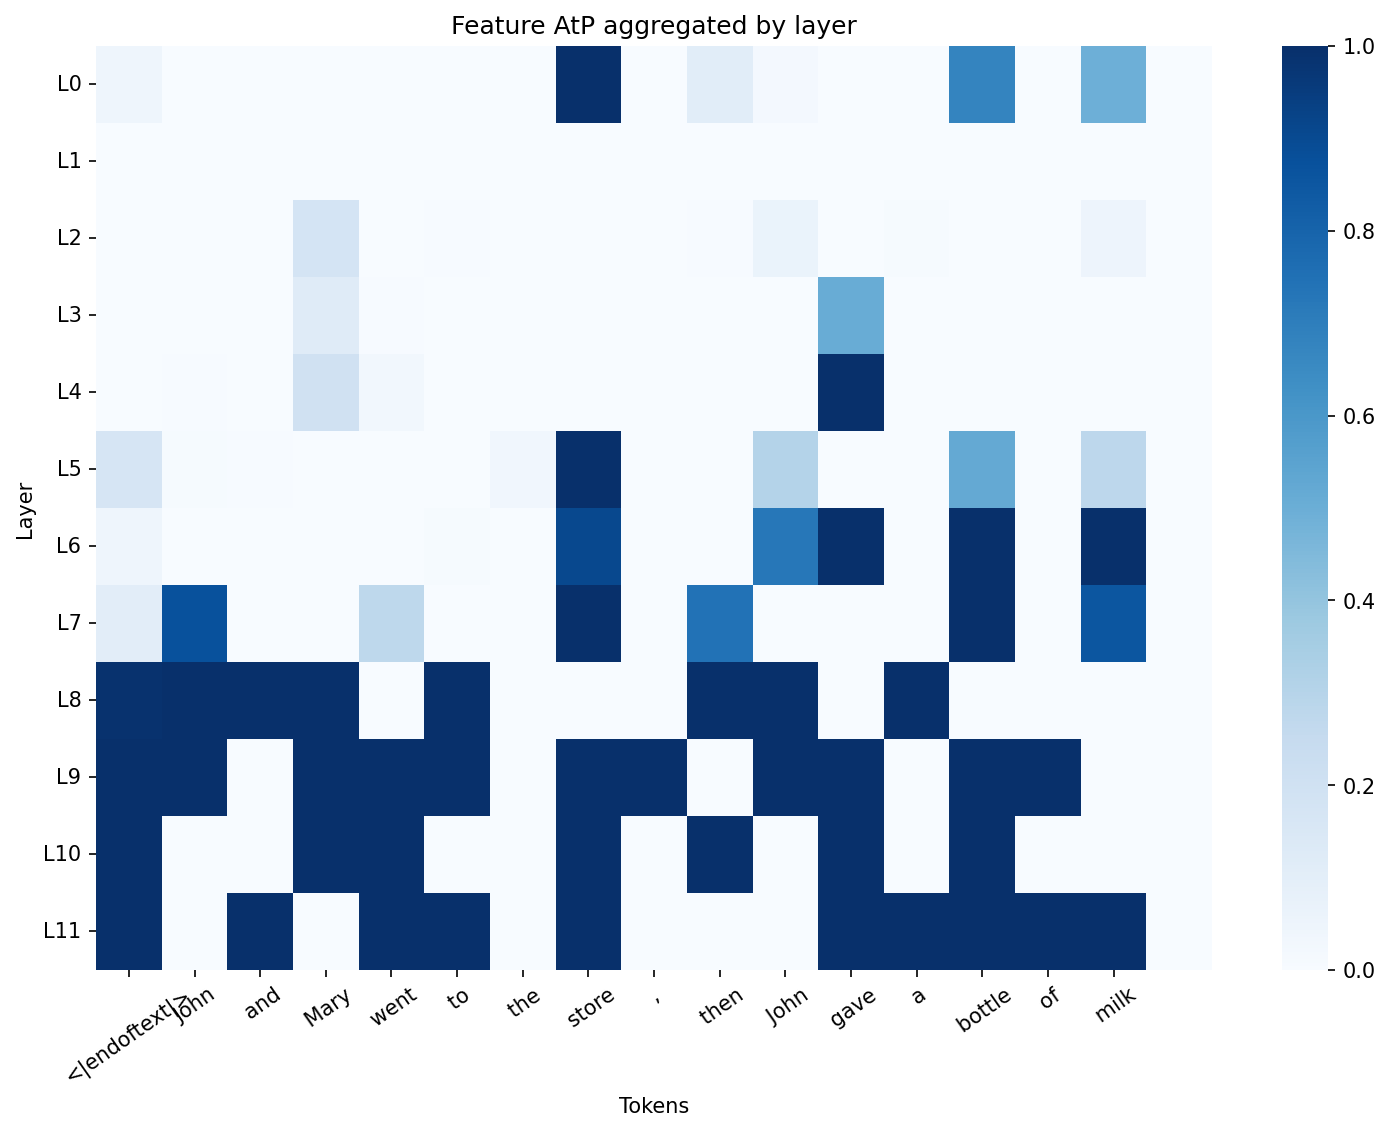

In [153]:
plt.figure(figsize=(12, 8), dpi=150)

ys = [f"L{i}" for i in range(model.cfg.n_layers)]

# Draw the heatmap
ax = sns.heatmap(patch.cpu().sum(-1), cmap='Blues', vmin=0, vmax=1)

# Set tick labels
ax.set_xticks([i + 0.5 for i in range(len(labels))])  # Set x-ticks every 10 columns
ax.set_yticks([i + 0.5 for i in range(len(ys))])  # Set y-ticks every 10 rows

# Set tick labels with optional custom labeling
ax.set_xticklabels(labels)
ax.set_yticklabels(ys)

# Rotate tick labels for better visibility
plt.xticks(rotation=35)
plt.yticks(rotation=0)

# Title and labels (optional)
plt.title('Feature AtP aggregated by layer')
plt.xlabel('Tokens')
plt.ylabel('Layer')

# Show the plot
plt.show()

In [170]:
def reconstr_hook(x, hook, sae):
    sae_out, f_act, *_ = sae(x)
    sae_cache[hook.name] = f_act  # Store for reference; not detach here as we need gradients
    return sae_out

def interpolate(input, baseline, steps=50):
    return [baseline + (float(i) / steps) * (input - baseline) for i in range(steps + 1)]


In [171]:
# IG
from functools import partial

# Generate baseline
baseline_tokens = torch.zeros_like(tokens)

# Interpolate between baseline and actual tokens
interpolated_inputs = interpolate(tokens, baseline_tokens, steps=50)

# Container for accumulated gradients
accumulated_grads = []

for interp_tokens in interpolated_inputs:
    # Run model forward with hooks
    out = model.run_with_hooks(
                interp_tokens,
                fwd_hooks=[
                    (
                        utils.get_act_name(component, layer_id),
                        partial(reconstr_hook, sae=saes[layer_id]),
                    ) for layer_id in range(model.cfg.n_layers)
                ]
            ).log_softmax(-1)
    
    # Target token
    ans = model.to_single_token('Mary')
    loss = -out[0, -1, ans]  # Assuming scalar output for simplification

    # Backward to get gradients on interpolated inputs
    loss.backward()

    # Collect gradients from SAE features
    for name in sae_cache:
        if sae_cache[name].grad is not None:
            if name not in accumulated_grads:
                accumulated_grads[name] = []
            accumulated_grads[name].append(sae_cache[name].grad.clone())

    # Zero all gradients for the next iteration
    model.zero_grad()

# Average the gradients across all steps
integrated_gradients = {name: torch.stack(grads).mean(0) * (tokens - baseline_tokens) for name, grads in accumulated_grads.items()}


IndexError: tensors used as indices must be long, int, byte or bool tensors

In [23]:
json_text = """{
    "question": "What's the capital of France?",
    "answer": Paris
    }"""

non_json_text = [
    """What's the capital of France?
Paris""",
    """These are the things I love:
1. Food,
2. Sea,
3. Friends""",
    """An old man once told me: "You will succeed in life".
I hope him to be true."""
]

In [7]:
features_dict = {l: [] for l in range(model.cfg.n_layers)}

with open("json_features.txt", "r") as f:
    features = f.readlines()

for f in features:
    f = f.strip().split('-')
    layer = int(f[0])
    features_dict[layer].append(f[1])

In [26]:
features_act_dict = {
    'L': [],
    'N': [],
    'JSON Activation': [],
    'Non-JSON Activation': []
}

with torch.no_grad():
    _, json_cache = model.run_with_cache(model.to_tokens(json_text))
    _, non_json_cache = model.run_with_cache(model.to_tokens(non_json_text[2]))

for l in range(model.cfg.n_layers):
    json_activations = json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]
    non_json_activations = non_json_cache[f'blocks.{l}.hook_resid_pre'] # [1 p dm]

    with torch.no_grad():
        _, json_features_act, *_ = saes[l](json_activations)
        _, non_json_features_act, *_ = saes[l](non_json_activations)

    for f in features_dict[l]:
        f = int(f)
        features_act_dict['L'].append(l)
        features_act_dict['N'].append(f)
        val, ix = json_features_act[0, :, f].max(0)
        features_act_dict['JSON Activation'].append([val.item(), ix.item()])
        val, ix = non_json_features_act[0, :, f].max(0)
        features_act_dict['Non-JSON Activation'].append([val.item(), ix.item()])        

In [27]:
import pandas as pd

pd.DataFrame(features_act_dict)

,L,N,JSON Activation,Non-JSON Activation
0,0,23622,"[0.0, 0]","[0.0, 0]"
1,1,5310,"[20.185184478759766, 8]","[0.0, 0]"
2,2,10521,"[25.650108337402344, 8]","[0.0, 0]"
3,4,21672,"[3.7655177116394043, 9]","[0.0, 0]"
4,4,8148,"[1.687551736831665, 18]","[0.0, 0]"
5,6,5682,"[24.25801658630371, 23]","[0.0, 0]"
6,6,3596,"[21.313154220581055, 2]","[0.0, 0]"
7,6,13428,"[0.9894517660140991, 8]","[0.0, 0]"
8,6,2164,"[0.0, 0]","[0.0, 0]"
9,7,20690,"[25.253623962402344, 23]","[0.0, 0]"


In [21]:
list(enumerate(model.to_str_tokens(json_text)))

[(0, '<|endoftext|>'),
 (1, '{'),
 (2, '\n'),
 (3, ' '),
 (4, ' '),
 (5, ' '),
 (6, ' "'),
 (7, 'question'),
 (8, '":'),
 (9, ' "'),
 (10, 'What'),
 (11, "'s"),
 (12, ' the'),
 (13, ' capital'),
 (14, ' of'),
 (15, ' France'),
 (16, '?",'),
 (17, '\n'),
 (18, ' '),
 (19, ' '),
 (20, ' '),
 (21, ' "'),
 (22, 'answer'),
 (23, '":'),
 (24, ' Paris'),
 (25, '\n'),
 (26, ' '),
 (27, ' '),
 (28, ' '),
 (29, ' }')]

## Sentiment Analysis

In [4]:
from datasets import load_dataset
from openai import OpenAI

llm = OpenAI(
           base_url = "https://api.endpoints.anyscale.com/v1",
           api_key=os.environ['ANYSCALE_API_KEY'],
        )

In [6]:
imdb = load_dataset('stanfordnlp/imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [58]:
import re
import json

def summarize(prompt, max_new_tokens=256):
    try:
        response = llm.chat.completions.create(
                    model = "meta-llama/Meta-Llama-3-70B-Instruct",
                    messages = [
                            {'role': 'user', 'content': f"Rewrite the following text in one sentence. Output only a single json file with a single field 'new_text'.\n{prompt}"},
                        ],
                    temperature=1,
                    max_tokens=max_new_tokens,
                )
                
        out = response.choices[0].message.content

        json_pattern = r"{.*?}"

        # Find all occurrences of JSON in the text
        match = re.findall(json_pattern, out)[0]
        json_data = json.loads(match)
        new_text = json_data["new_text"]

        return new_text
    except Exception as e:
        return out

In [49]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

df = pd.DataFrame(imdb['train']).groupby('label').sample(250, random_state=42)
df['summary'] = df['text'].progress_apply(summarize)

100%|██████████| 500/500 [41:20<00:00,  4.96s/it]


In [200]:
df = pd.read_csv("imdb.csv")

### Baseline

In [268]:
n_shots = 8

train = pd.concat([
    df.iloc[:n_shots//2],
    df.iloc[250:250+n_shots//2],
], axis=0)

test = pd.concat([
    df.iloc[n_shots//2:250],
    df.iloc[250+n_shots//2:],
], axis=0)

In [269]:
import random

map = {
    1: 'positive',
    0: 'negative'
}

def generate_prompt(x, shots):
    prompt = ""

    for i in random.sample(range(n_shots), n_shots):
        shot = shots.iloc[i]
        prompt += f"{shot['summary']} | {map[shot['label']]}\n\n"

    prompt += x + " |"
    return prompt

In [270]:
tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
preds = []
for i in tqdm(range(len(test))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], train)
    
    with torch.no_grad():
        proba = model(model.to_tokens(prompt)).softmax(-1)

    preds.append(proba[0, -1, tokens].tolist())

preds = np.array(preds)
test['pred_positive'] = preds[:, 0]
test['pred_negative'] = preds[:, 1]

100%|██████████| 492/492 [05:24<00:00,  1.52it/s]


In [271]:
test['pred'] = test.apply(lambda x: 1 if x['pred_positive'] > x['pred_negative'] else 0, axis=1)
test['correct'] = test['label'] == test['pred']

Patterns have a strong effect on ICL, if examples are given in a strong pattern (such as pos, neg, pos, neg, ...) then the model will follow the pattern and won't reason about the sentence.

In [273]:
test.groupby('label')['correct'].mean()

label
0    0.479675
1    0.467480
Name: correct, dtype: float64

### Heads Boost

In [274]:
def head_modifier_hook(x, hook, head_id, lam=1.2):
    x[:, -1, head_id, :] = lam * x[:, -1, head_id, :]
    return x

In [276]:
prompt = generate_prompt(test.iloc[-2]['summary'], train)
print(prompt)

This film about a vengeful ghost is an unremarkable combination of GASLIGHT and LES DIABOLIQUES, featuring 10 big-name stars, including Cliff Robertson and Jean Simmons, despite its cliché-ridden and mediocre script. | negative

I saw The Glacier Fox at age nine and have been searching for it on video, hoping it will be re-released or picked up by a new distributor for regular showings, as it's a captivating film with a great soundtrack that would resonate with today's audiences. | positive

Reed Hadley's serial features the best theme song and Yakima Canutt's incredible stagecoach stunt, making it a must-see despite its lower budget and Hadley's less impressive portrayal of Zorro. | positive

This film chronicles the attempts of an elderly saxophone player to reform her all-girl band from WWII, featuring an all-star cast including Ian Holm, Judi Dench, and Leslie Caron, in a nostalgic and entertaining romp down memory lane. | positive

The movie 'The Wayward Cloud' features disturbing

In [279]:
# [(8, 11, -1), (9, 6, 1), (9, 9, 1), (10, 0, 1), (10, 1, 1), (10, 7, -1), (10, 10, 1), (11, 10, -1)]
heads = [(8, 11), (9, 6), (10, 0), (10, 1)]

topk_token_probas = []  # List to store topk token probabilities
lams = np.linspace(1, 15, 20)

for lam in tqdm(lams):
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)
        
        vals = proba[..., tokens]
        
        topk_token_probas.append(vals[0, -1, :].cpu().numpy().tolist())


100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


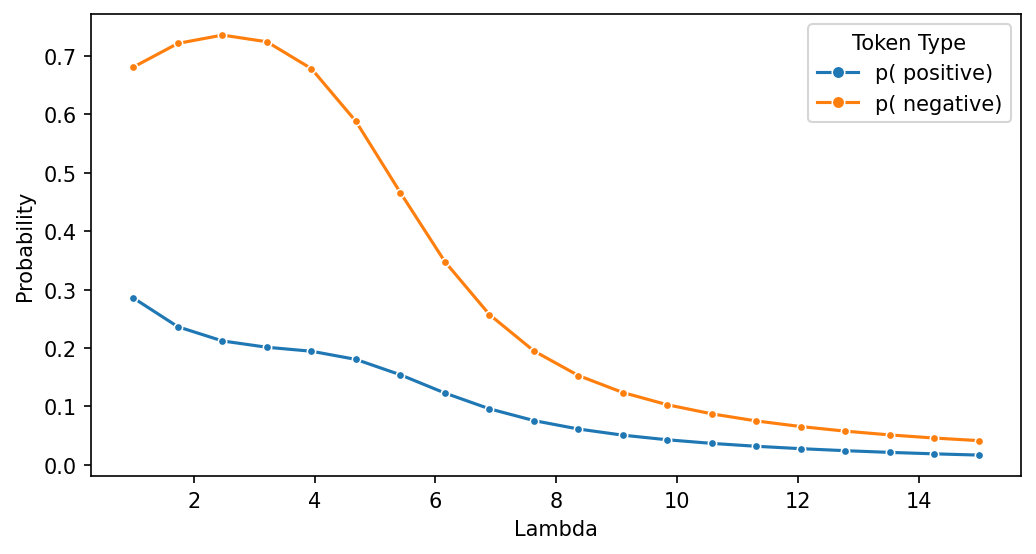

In [280]:
import pandas as pd

fig = plt.figure(figsize=(8, 4), dpi=150)

data = pd.DataFrame(topk_token_probas, columns=[f"p({tok})" for tok in model.to_str_tokens(torch.tensor(tokens))])
data['Lambda'] = lams
data = data.melt(id_vars='Lambda', var_name='Token Type', value_name='Probability')

ax = sns.lineplot(data=data, x='Lambda', y='Probability', hue='Token Type', marker='o')
tmp =[line.set_markersize(4) for line in ax.lines]

In [281]:
lam = 7

tokens = model.to_tokens(prompt)
max_new_tokens = 4

for i in tqdm(range(max_new_tokens)): 
    with torch.no_grad():
        new_tok = model.run_with_hooks(
            tokens,
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).argmax(-1)[:, -1, None]

    tokens = torch.cat([tokens, new_tok], dim=-1)

print(model.to_string(tokens)[0])

100%|██████████| 4/4 [00:02<00:00,  1.66it/s]

<|endoftext|>This film about a vengeful ghost is an unremarkable combination of GASLIGHT and LES DIABOLIQUES, featuring 10 big-name stars, including Cliff Robertson and Jean Simmons, despite its cliché-ridden and mediocre script. | negative

I saw The Glacier Fox at age nine and have been searching for it on video, hoping it will be re-released or picked up by a new distributor for regular showings, as it's a captivating film with a great soundtrack that would resonate with today's audiences. | positive

Reed Hadley's serial features the best theme song and Yakima Canutt's incredible stagecoach stunt, making it a must-see despite its lower budget and Hadley's less impressive portrayal of Zorro. | positive

This film chronicles the attempts of an elderly saxophone player to reform her all-girl band from WWII, featuring an all-star cast including Ian Holm, Judi Dench, and Leslie Caron, in a nostalgic and entertaining romp down memory lane. | positive

The movie 'The Wayward Cloud' featur

In [282]:
tokens = [model.to_single_token(tok) for tok in [' positive', ' negative']]
lam = 7

preds = []
for i in tqdm(range(len(test))):
    x = test.iloc[i]
    prompt = generate_prompt(x['summary'], train)
    
    with torch.no_grad():
        proba = model.run_with_hooks(
            model.to_tokens(prompt),
            fwd_hooks=[
                (
                    f"blocks.{l}.attn.hook_result",
                    partial(head_modifier_hook, head_id=h, lam=lam),
                ) for l, h in heads
            ]
        ).softmax(-1)

    preds.append(proba[0, -1, tokens].tolist())

preds = np.array(preds)
test['boost_pred_positive'] = preds[:, 0]
test['boost_pred_negative'] = preds[:, 1]

100%|██████████| 492/492 [03:57<00:00,  2.07it/s]


In [283]:
test['boost_pred'] = test.apply(lambda x: 1 if x['boost_pred_positive'] > x['boost_pred_negative'] else 0, axis=1)
test['boost_correct'] = test['label'] == test['boost_pred']

In [284]:
test.groupby('label')['boost_correct'].mean()

label
0    1.000000
1    0.077236
Name: boost_correct, dtype: float64